In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [19]:
df_transaction = pd.read_csv("../Data Cafe test/Data Cafe Test Before Interview/dh_transactions.csv",sep=',')
df_product = pd.read_csv('../Data Cafe test/Data Cafe Test Before Interview/dh_product_lookup.csv',sep=",")

df = df_transaction.merge(df_product[['upc','product_description','commodity','brand','product_size']], how='left', on='upc')

# Create features
df['month'] = df_transaction['week'] % 12 # 1 is jan, 0 is dec
df['day_of_week'] = df_transaction['day'] % 7 # 1 is monday, 0 is sunday
df['week_of_month'] = (df_transaction['day'] // 7) % 4 + 1

In [20]:
month_names = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
               7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 0: "Dec"}

day_of_week_names = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday",
                     5: "Friday", 6: "Saturday", 0: "Sunday"}

# We should keep the numerical data for ML.
df['month_name'] = df['month'].map(month_names)
df['day_of_week_name'] = df['day_of_week'].map(day_of_week_names)

In [21]:
df['upc'] = df['upc'].astype(str)
df['geography'] = df['geography'].astype(str)
df['store'] = df['store'].astype(str)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197681 entries, 0 to 5197680
Data columns (total 20 columns):
 #   Column               Dtype  
---  ------               -----  
 0   upc                  object 
 1   dollar_sales         float64
 2   units                int64  
 3   time_of_transaction  int64  
 4   geography            object 
 5   week                 int64  
 6   household            int64  
 7   store                object 
 8   basket               int64  
 9   day                  int64  
 10  coupon               int64  
 11  product_description  object 
 12  commodity            object 
 13  brand                object 
 14  product_size         object 
 15  month                int64  
 16  day_of_week          int64  
 17  week_of_month        int64  
 18  month_name           object 
 19  day_of_week_name     object 
dtypes: float64(1), int64(10), object(9)
memory usage: 793.1+ MB


In [23]:
# Drop uneccessay columns
df = df.drop(['basket','product_description', 'month', 'day', 'week', 'product_size'], axis=1)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197681 entries, 0 to 5197680
Data columns (total 14 columns):
 #   Column               Dtype  
---  ------               -----  
 0   upc                  object 
 1   dollar_sales         float64
 2   units                int64  
 3   time_of_transaction  int64  
 4   geography            object 
 5   household            int64  
 6   store                object 
 7   coupon               int64  
 8   commodity            object 
 9   brand                object 
 10  day_of_week          int64  
 11  week_of_month        int64  
 12  month_name           object 
 13  day_of_week_name     object 
dtypes: float64(1), int64(6), object(7)
memory usage: 555.2+ MB


In K-Means clustering we have to convert some columns from int64 to object or string.

Then, we will use One-Hot Encoding to make them be binary features.

And there are many column, so we will use sklearn Pipeline

In [25]:
# select columns for different preprocessing
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64','float64']).columns.tolist()

In [26]:
print(categorical_features)
print()
print(numerical_features)

['upc', 'geography', 'store', 'commodity', 'brand', 'month_name', 'day_of_week_name']

['dollar_sales', 'units', 'time_of_transaction', 'household', 'coupon', 'day_of_week']


In [27]:
# Create preprocessing pipelines

# JUST IN CASE that there are still have null values in numerical type columns.
numerical_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                                     ("scaler", StandardScaler())
                                     ]) 

# 'imputer' just in case that there are still have null values in object type columns.
# apply one-hot encoder to object type column
object_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
                                       ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                       ])

In [28]:
# Combine preprocessor pipeline
preprocessor = ColumnTransformer(
                transformers=[
                    ("num", numerical_pipeline, numerical_features),
                    ("obj", object_pipeline, categorical_features)
                ]
)

In [29]:
# Preprocessing the data
X_preprocessed = preprocessor.fit_transform(df)
df.isnull().sum(), numerical_features

(upc                    0
 dollar_sales           0
 units                  0
 time_of_transaction    0
 geography              0
 household              0
 store                  0
 coupon                 0
 commodity              0
 brand                  0
 day_of_week            0
 week_of_month          0
 month_name             0
 day_of_week_name       0
 dtype: int64,
 ['dollar_sales',
  'units',
  'time_of_transaction',
  'household',
  'coupon',
  'day_of_week'])

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


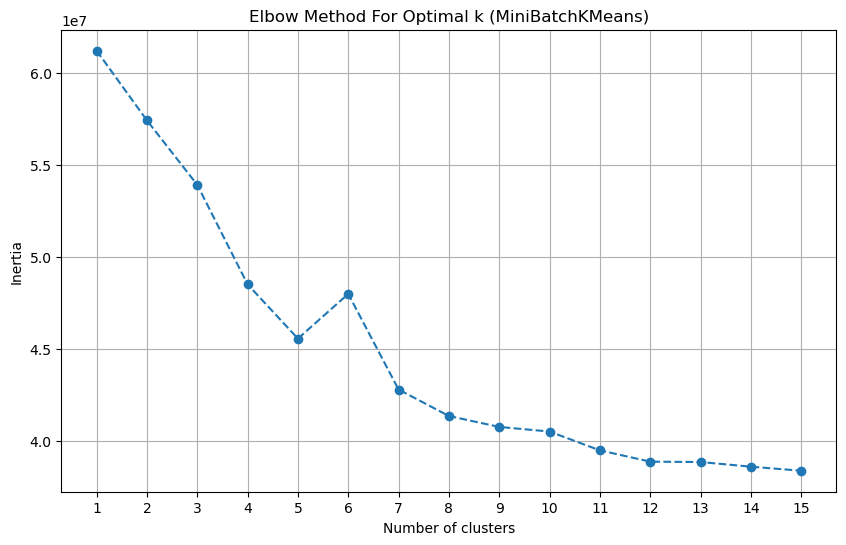

In [30]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(1, 16)

for k in k_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_preprocessed)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k (MiniBatchKMeans)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/anacon

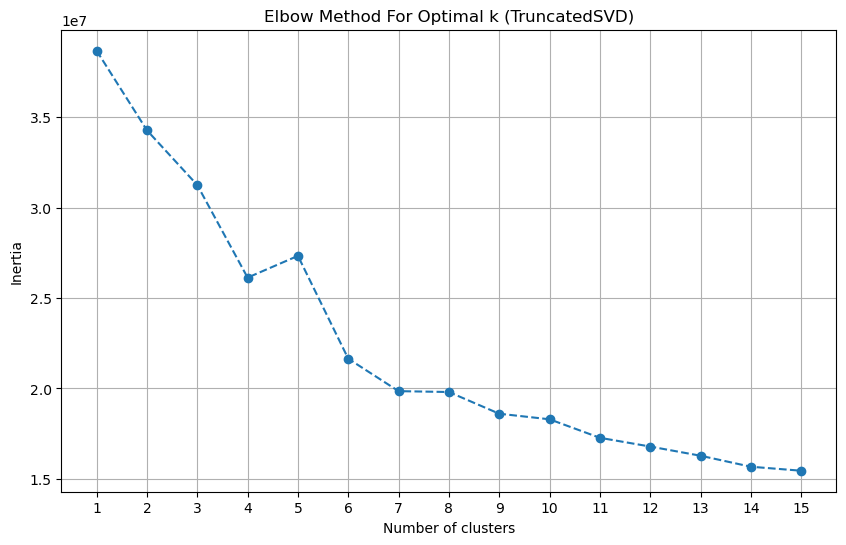

In [31]:
# Use TruncatedSVD:
# The error message suggests TruncatedSVD (Truncated Singular Value Decomposition) as a viable alternative.
# TruncatedSVD is similar to PCA but can handle sparse matrices efficiently.

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=10)
X_preprocessed_reduced = svd.fit_transform(X_preprocessed)

inertia = []
k_range = range(1, 16)

for k in k_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_preprocessed_reduced)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k (TruncatedSVD)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

### Proceeding with K-means clustering using 9 clusters

In [38]:
kmeans_final = KMeans(n_clusters=12, random_state=42)
kmeans_final.fit(X_preprocessed)

# Assign the clusters to the original data
df["Cluster"] = kmeans_final.labels_

# Analyz the characteristics of each cluster
numerical_summary = df.groupby("Cluster").mean(numeric_only=True)


# use this code when we want to find categorical_summary.

# categorical_summary = df.groupby("Cluster").agg(lambda x: x.mode()[0] if x.dtype=='object' else x.mean())  # Mode for categorical, mean for numerical
# cluster_summary = pd.concat([numerical_summary, categorical_summary], axis=1)
# Combine the summaries into a single DataFrame

# Print the cluster summary (transposed for better readability)
numerical_summary

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,dollar_sales,units,time_of_transaction,household,coupon,day_of_week,week_of_month
Cluster,,,,,,,
0,1.552848,1.095821,1555.243638,79806.468327,0.000000,5.016231,2.522039
1,0.987845,1.000181,1708.266903,318871.472716,0.000000,1.453777,2.501075
2,4.402493,1.983560,1543.979553,220498.913578,0.000000,3.055511,2.511988
3,1.458075,1.240298,1492.824338,215905.398409,1.000000,2.835317,2.578083
4,1.565548,1.034748,1806.044070,322190.323785,0.000000,5.032560,2.525000
5,2.050464,1.014771,1789.888568,321562.831122,0.000000,1.469987,2.508368
6,1.549570,1.057572,1079.343580,299926.863689,0.000000,4.541517,2.538022
7,1.110635,1.089879,1515.179893,80059.282326,0.000000,1.304960,2.498286
8,6.140980,4.795069,1487.005208,221292.908265,0.005261,2.937055,2.595765
